In [1]:
#%pip install pip install sb3-contrib

In [1]:
import os
import numpy as np
import pandas as pd
import yfinance as yf
import random
from gym import Env
from gym.spaces import Discrete, Box
import matplotlib.pyplot as plt
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import BaseCallback
from sb3_contrib import RecurrentPPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy

In [2]:
class TrainAndLoggingCallback(BaseCallback):
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)
        
    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

In [3]:
def getTickerData(ticker, period, interval):
    hist = yf.download(tickers = ticker, period=period, interval=interval)
    df = pd.DataFrame(hist)
    df = df.reset_index()
    return df

In [4]:
df = getTickerData('btc-usd', 'max', '1d')
df = df.drop(columns={'Volume', 'Adj Close', 'Open', 'High', 'Low'})
df = df.rename(columns={'Close': 'close', 'Date': 'date'})
df['date'] = pd.to_datetime(df['date'])
df

[*********************100%***********************]  1 of 1 completed


,date,close
0,2014-09-17,457.334015
1,2014-09-18,424.440002
2,2014-09-19,394.795990
3,2014-09-20,408.903992
4,2014-09-21,398.821014
...,...,...
3142,2023-04-25,28307.597656
3143,2023-04-26,28422.701172
3144,2023-04-27,29473.787109
3145,2023-04-28,29340.261719


In [589]:
rn = random.randint(0, df.value_counts().sum())
i=0
df.shape[0] - rn

1166

8672.455078125


,date,close
1985,2020-02-23,9924.515625
1986,2020-02-24,9650.174805
1987,2020-02-25,9341.705078
1988,2020-02-26,8820.522461
1989,2020-02-27,8784.494141


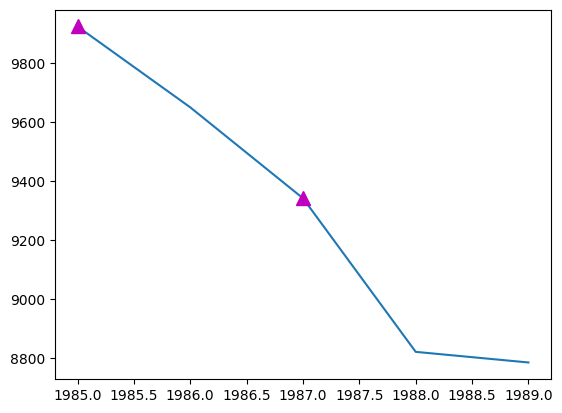

In [594]:
df2 = df.iloc[rn+i:rn+5+i,:]
final_value = df.loc[rn+5+i]['close']
close_value = df.loc[rn+4+i]['close']
plt.plot(df2['close'])
plt.plot(df2['close'], '^', markersize=10, color='m', label = 'buying signal', markevery = [True, False, True, False, False])
print(final_value)
i+=1
df2

In [904]:
class TradingEnv(Env):
    def __init__(self, df, n_steps, window_size) -> None:
        super().__init__()
        self.df = df.drop(columns={'date'})
        self.window_size = window_size
        self.observation_space = Box(low=-np.inf, high=np.inf, shape=(window_size, self.df.shape[1]), dtype=np.float64)
        self.action_space = Discrete(2) # 0-short pos; 1-long pos
        self.done = None
        
        self.current_step = 0
        self.n_steps = n_steps
        self.random_index = random.randint(0, df.value_counts().sum())
        
        self.final_value = df.iloc[self.random_index+self.window_size+self.current_step-1]['close']
        self.next_value = df.iloc[self.random_index+self.window_size+self.current_step]['close']
        
        self.long_pos = []
        self.short_pos = []
        
    def step(self, action):
        if action == 0:
            self.short_pos.append(True)
            self.long_pos.append(False)
        else:
            self.short_pos.append(False)
            self.long_pos.append(True)
        
        self.final_value = df.iloc[self.random_index+self.window_size+self.current_step-1]['close']
        self.next_value = df.iloc[self.random_index+self.window_size+self.current_step]['close']
        reward = self.calculate_reward(action)
        
        self.current_step += 1
        
        if self.current_step >= self.n_steps:
            done = True
            self.short_pos.append(False)
            self.long_pos.append(False)
        else:
            done = False
        
        observation = self.get_observation()
        info = {}
        
        return observation, reward, done, info
        
    def reset(self):
        next_observation = self.get_observation(is_random=True)
        self.random_index = random.randint(0, df.value_counts().sum())
        self.done = False
        self.current_step = 0
        self.long_pos.clear()
        self.short_pos.clear()
        next_observation = self.get_observation(is_random=True)
        self.final_value = df.iloc[self.random_index+self.window_size+self.current_step-1]['close']
        self.next_value = df.iloc[self.random_index+self.window_size+self.current_step]['close']
        return next_observation
    
    def get_observation(self, is_random=False):
        needed_space = self.window_size + self.n_steps*2
        if is_random:
            self.random_index = random.randint(0, df.value_counts().sum())
            if df.shape[0] - self.random_index < needed_space+1:
                self.random_index = df.shape[0] - needed_space
        return self.df.iloc[self.random_index+self.current_step:self.random_index+self.window_size+self.current_step, :].values
    
    def render_final(self):
        final_observation = self.df.iloc[self.random_index+self.window_size-1:self.random_index+self.window_size+self.n_steps]
        plt.figure(figsize=(10,5))
        plt.plot(final_observation, color='c', lw=2.)
        plt.plot(final_observation, '^', markersize=10, color='g', label = 'buying signal', markevery = self.long_pos)
        plt.plot(final_observation, 'v', markersize=10, color='r', label = 'selling signal', markevery = self.short_pos)
        plt.title("Final result of the last trading session")
        plt.legend()
        plt.plot()
    
    def calculate_reward(self, action):
        """Calculate the reward function for the model here
        Example:
        if action == 0:
            if self.next_value < self.final_value:
                reward = 1
            else:
                reward = -1
        if action == 1:
            if self.next_value > self.final_value:
                reward = 1
            else:
                reward = -1
                
        return reward"""
        raise NotImplementedError    

In [905]:
class Trading(TradingEnv):
    def __init__(self, df, n_steps, window_size) -> None:
        super().__init__(df, n_steps, window_size)
    
    def calculate_reward(self, action):
        if action == 0:
            if self.next_value < self.final_value:
                reward = 1
            else:
                reward = -1
        if action == 1:
            if self.next_value > self.final_value:
                reward = 1
            else:
                reward = -1
                
        return reward

In [906]:
env = Trading(df, window_size=10, n_steps=6)

In [907]:
check_env(env)

c:\Users\damem\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\env_checker.py:213: UserWarning: Your observation  has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(


reward 1
reward -1
reward -1
reward 1
reward 1
reward -1
episode - 1 || score - 0


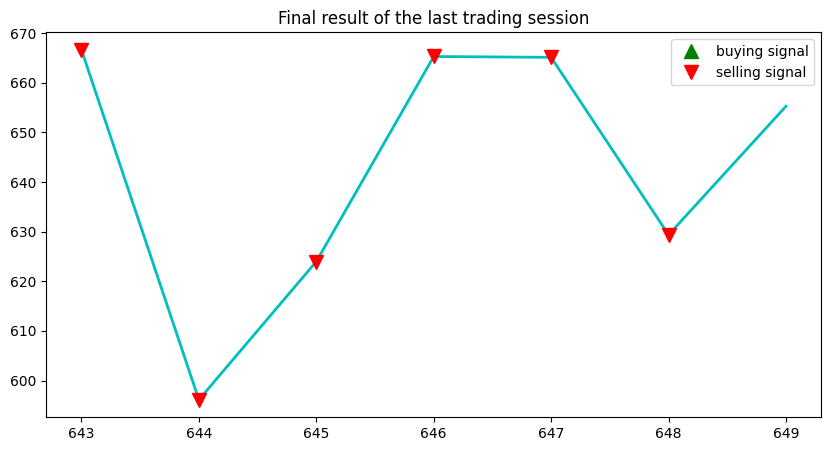

In [914]:
episodes = 1
for n in range(1, episodes+1):
    obs = env.reset()
    done = False
    score = 0
    steps_taken = 0
    while not done:
        action = env.action_space.sample()
        #print(f'action {action}')
        obs, reward, done, info = env.step(action)
        score += reward
        steps_taken+=1
        print(f'reward {reward}')
    env.render_final()
    print(f'episode - {n} || score - {score}')

In [469]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [470]:
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

In [471]:
model = RecurrentPPO('MlpLstmPolicy', env, verbose=1, tensorboard_log=LOG_DIR, learning_rate=0.0001)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [472]:
model.learn(total_timesteps=10000, callback=callback)

Logging to ./logs/RecurrentPPO_5
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 2        |
| time/              |          |
|    fps             | 135      |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 128      |
---------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 2.5           |
| time/                   |               |
|    fps                  | 114           |
|    iterations           | 2             |
|    time_elapsed         | 2             |
|    total_timesteps      | 256           |
| train/                  |               |
|    approx_kl            | 0.00031423522 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.693        |
|    explai

In [475]:
loaded_model = RecurrentPPO.load('./train/best_model_10000.zip')

In [537]:
evaluate_policy(loaded_model, env, n_eval_episodes=10)

c:\Users\damem\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


(1.2, 4.4)

episode - 1 || score - 2


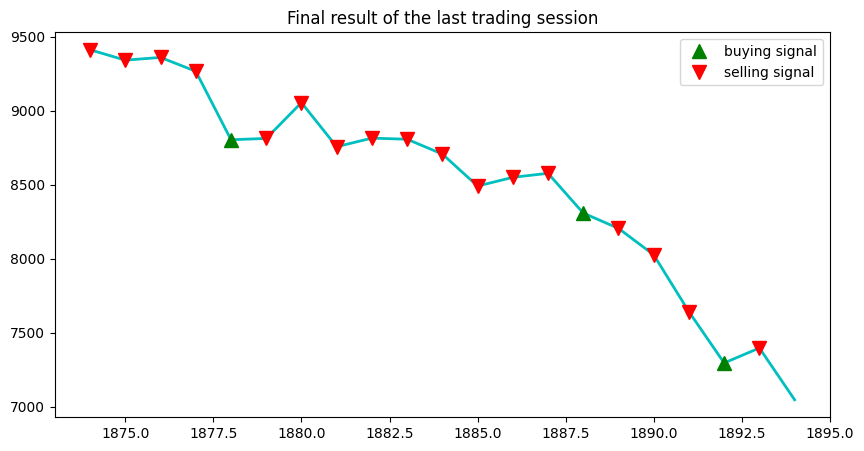

In [616]:
episodes = 1
for n in range(1, episodes+1):
    obs = env.reset()
    done = False
    score = 0
    steps_taken = 0
    while not done:
        action, lstm_cells = loaded_model.predict(obs)
        obs, reward, done, info = env.step(action)
        score += reward
        steps_taken+=1
    env.render_final()
    print(f'episode - {n} || score - {score}')